# Movie recommender system with Spark machine learning

In this [Jupyter](http://jupyter.org/) notebook, you will use Apache Spark and the Spark machine learning library to build a recommender system for movies with a data set from MovieLens. You'll also learn how to manage Spark performance.

Some familiarity with Python is recommended. This notebook runs on Python 2.7 with Spark 2.0.


## MovieLens
<a href="https://movielens.org/" target="_blank" rel="noopener noreferrer">MovieLens</a> is a project developed by <a href="https://grouplens.org/" target="_blank" rel="noopener noreferrer">GroupLens</a>, a research laboratory at the University of Minnesota. MovieLens provides an online movie recommender application that uses anonymously-collected data to improve recommender algorithms. Anyone can try the app for free and get movies recommendations. To help people develop the best recommendation algorithms, MovieLens also released several data sets. In this notebook, you'll use the latest data set, which has two sizes.

The full data set consists of more than 24 million ratings across more than 40,000 movies by more than 250,000 users. The file size is kept under 1GB by using indexes instead of full string names. 

The small data set that you'll use in this notebook is a subset of the full data set. It's generally a good idea to start building a working program with a small data set to get faster performance while interacting, exploring, and getting errors with your data. When you have a fully working program, you can apply the same code to the larger data set, possibly on a larger cluster of processors. You can also minimize memory consumption by limiting the data volume as much as possible, for example, by using indexes. 

## Spark machine learning library
[Apache Spark’s machine learning library](http://spark.apache.org/docs/latest/ml-guide.html) makes practical machine learning scalable and easy. The library consists of common machine learning algorithms and utilities, including classification, regression, clustering, collaborative filtering (this notebook!), dimensionality reduction, lower-level optimization primitives, and higher-level pipeline APIs.

The library has two packages:
- `spark.mllib` contains the original API that handles data in RDDs. It's in maintenance mode, but fully supported.
- `spark.ml` contains a newer API for constructing ML pipelines. It handles data in DataFrames. It's being actively enhanced.

You'll use the `spark.ml` package in this notebook.


## Table of contents

1. [Load the data](#1.-Load-the-data)<br>
    1.1 [Download the data from MovieLens](#1.1-Download-the-data-from-MovieLens)<br>
    1.2 [Load movies.csv](#1.2-Load-movies.csv)<br>
    1.3 [Load ratings.csv](#1.3-Load-ratings.csv)<br>
2. [Spark performance basics](#2.-Spark-performance-basics)
3. [Explore the data with Spark APIs](#3.-Explore-the-data-with-Spark-APIs)
4. [Visualize the data](#4.-Visualize-the-data)
5. [Build the recommender system](#5.-Build-the-recommender-system)<br>
    5.1 [Train the model](#5.1-Train-the-model)<br>
    5.2 [Run the model](#5.2-Run-the-model)<br>
    5.3 [Evaluate the model](#5.3-Evaluate-the-model)<br>
    5.4 [Split the data set](#5.4-Split-the-data-set)<br>
    5.5 [Handle NaN results](#5.5-Handle-NaN-results)<br>
    5.6 [Improve the performance score](#5.6-Improve-the-performance-score)<br>
    5.7 [Improve the model](#5.7-Improve-the-model)<br>
    5.8 [Recommend movies](#5.8-Recommend-movies)<br>
6. [Summary and next steps](#6.-Summary-and-next-steps)

## 1. Load the data

You'll create Spark DataFrames, which are similar to R or pandas DataFrames, but can be distributed on a cluster of Spark executors, which can potentially scale up to thousands of machines. DataFrames are one of the easiest and best performing ways of manipulating data with Spark, but they require structured data in formats or sources such as CSV, Parquet, JSON, or JDBC.

### 1.1 Download the data from MovieLens
To download the data:

1. Download the small version of the `ml-latest.zip` file from <a href="https://grouplens.org/datasets/movielens/latest/" target="_blank" rel="noopener noreferrer">MovieLens Latest DataSets</a>.
1. Unzip the file. The files you'll be using are `movies.csv` and `ratings.csv`.

### 1.2 Load movies.csv
To load the movies.csv file into a Spark DataFrame:

1. Click the **Find and Add Data** button on the notebook action bar (the 1010 button at the top right of this page). Drop the files into the box or browse to select the files. The files are loaded to your object storage and also appear in the **Data Assets** section of your project.
1. Click in the following code cell.
1. Under the `movies.csv` file, click **Insert to code > Insert SparkSession DataFrame**. The DataFrame is named `df_data_1` by default.
1. Rename the DataFrame by changing `df_data_n` to `movies` in the last row and four rows above that and run the cell.

In [1]:
# Click here to create your DataFrame


[Row(movieId=u'1', title=u'Toy Story (1995)', genres=u'Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=u'2', title=u'Jumanji (1995)', genres=u'Adventure|Children|Fantasy'),
 Row(movieId=u'3', title=u'Grumpier Old Men (1995)', genres=u'Comedy|Romance'),
 Row(movieId=u'4', title=u'Waiting to Exhale (1995)', genres=u'Comedy|Drama|Romance'),
 Row(movieId=u'5', title=u'Father of the Bride Part II (1995)', genres=u'Comedy')]

The `# @hidden_cell` tag hides your credentials when you use the **Share** button to share this notebook with people who are not collaborators on your project. Be aware that this tag does NOT prevent those cells from being published when you publish your notebook on GitHub!

Look at the `spark.read` code block. This is where the data is loaded from your OpenStack Swift container. The Uniform Resource Identifier (URI) `swift://<container_name>.<keystone>/<file_name>` gives access to your data repository:

- `<keystone>` = the connection parameters (username, password, API endpoint, and so on), defined with the `set_hadoop_config_...` function.
- `<container_name>` = the container where you store the data, which was defined when you created your project. You can see the container name in the **Storage** section on the project **Settings** page. The default name is the name of your project without spaces. 
- `<file_name>` = the name of the file to access.

In the following cell, set these variables so you can use them later. Substitute `YOUR_CONTAINER_NAME` with your container name.

In [2]:
container_name = 'YOUR_CONTAINER_NAME' # substitute your container name
movies_file_name = 'movies.csv'
ratings_file_name = 'ratings.csv'

### 1.3 Load ratings.csv

Now load the `ratings.csv` file. Add the file to the **Files** pane and load the data in one of the following ways:

 - Delete the code in the next cell. Run **Insert to code > Insert SparkSession DataFrame** and then rename the DataFrame by changing `df_data_n` to `ratings` in the first and last row. Then run the cell.
 - Run the code in the next cell.

Notice that there's much less code. That's because your credentials are needed only once in a notebook. 

In [3]:
# Click in this cell, remove the following code, then click Insert to code > Insert SparkSession DataFrame under ratings.csv.
# Or you can keep this code as it if you correctly defined the variables in the previous cell
ratings = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://' + container_name + '.' + name + '/' + ratings_file_name)
ratings.take(5)

[Row(userId=u'1', movieId=u'31', rating=u'2.5', timestamp=u'1260759144'),
 Row(userId=u'1', movieId=u'1029', rating=u'3.0', timestamp=u'1260759179'),
 Row(userId=u'1', movieId=u'1061', rating=u'3.0', timestamp=u'1260759182'),
 Row(userId=u'1', movieId=u'1129', rating=u'2.0', timestamp=u'1260759185'),
 Row(userId=u'1', movieId=u'1172', rating=u'4.0', timestamp=u'1260759205')]

## 2. Spark performance basics

Spark runs jobs in parallel on an executors cluster. You need a SparkSession instance to submit jobs. In DSX, a SparkSession is automatically created, as `spark`. You can read the [SparkContext](http://spark.apache.org/docs/2.0.2/api/python/pyspark.html#pyspark.SparkContext) and [SparkSession](http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.SparkSession) documentation to learn about the methods you can call on the `sc` and `spark` instances. Because Spark is written in Scala, the [Scala documentation](http://spark.apache.org/docs/2.0.2/api/scala/#package) tends to be more current and complete. 

Show the Spark version:

In [4]:
print spark.version

2.0.2


Show the default parallelism factor, which is the default number of partitions if you do not specify one:

In [5]:
print sc.defaultParallelism

2


Here's how you can see the details of the Spark configuration:

In [6]:
print sc.getConf().toDebugString()

hive.metastore.warehouse.dir=file:/gpfs/global_fs01/sym_shared/YPProdSpark/user/sc3e-53554f95eddadf-4e28db014a7c/notebook/work/spark-warehouse
spark.app.id=app-20170323143154-0111-3a93496c-f7ee-4660-8342-18eb5a15407c
spark.app.name=PySparkShell
spark.deploy.resourceScheduler.factory=org.apache.spark.deploy.master.EGOResourceSchedulerFactory
spark.driver.host=10.143.133.129
spark.driver.maxResultSize=1210M
spark.driver.memory=1512M
spark.driver.port=37020
spark.eventLog.dir=/gpfs/fs01/user/sc3e-53554f95eddadf-4e28db014a7c/events
spark.eventLog.enabled=true
spark.executor.extraJavaOptions=-Djava.security.egd=file:/dev/./urandom
spark.executor.id=driver
spark.executor.memory=6G
spark.extraListeners=com.ibm.spaas.listeners.DB2DialectRegistrar
spark.history.fs.logDirectory=/gpfs/fs01/user/sc3e-53554f95eddadf-4e28db014a7c/events
spark.logConf=true
spark.master=spark://yp-spark-dal09-env5-0042:7085
spark.port.maxRetries=512
spark.r.command=/usr/local/src/bluemix_jupyter_bundle.v36/R/bin/Rscri

Spark DataFrames are distributed collections across a cluster of Spark executors. One of the key factors for ensuring that a Spark job is well distributed across the cluster is the number of partitions for a DataFrame. Run the `getNumPartitions()` method to show the number of partitions for each DataFrame: 

In [7]:
print "Number of partitions for the movies DataFrame: " + str(movies.rdd.getNumPartitions())
print "Number of partitions for the ratings DataFrame: " + str(ratings.rdd.getNumPartitions())

Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


Despite the `defaultParallelism`, the Spark DataFrameReader that we used only used a single Spark partition, which means all subsequent Spark operations would only run on a single executor.

You can run the `repartition()` method to redistribute the ratings data across multiple partitions. But be aware that repartition can involve a great deal of network bandwidth while data is transfered across the cluster! Because Spark DataFrames are immutable, you have to create a new DataFrame to repartition an existing DataFrame.

Create the `repartitionedRatings` DataFrame across 10 partitions:

In [8]:
repartitionedRatings = ratings.repartition(10)
print "Number of partitions for the ratings DataFrame: " + str(ratings.rdd.getNumPartitions())
print "Number of partitions for the repartitionedRatings DataFrame: " + str(repartitionedRatings.rdd.getNumPartitions())

Number of partitions for the ratings DataFrame: 1
Number of partitions for the repartitionedRatings DataFrame: 10


One of the key feature of Apache Spark is to leverage the memory as much as possible. While an action is in progress, data is loaded to memory and transformed several times before getting a result. But at the end of the processing, the memory is released. You can use the `.cache()` method to retain and persist a data set in memory as soon as you run an action on it. 

Load the `movies` and `ratings` data sets in memory to improve performance:

In [9]:
print "Number of ratings: " + str(repartitionedRatings.count())

Number of ratings: 100004


In [10]:
repartitionedRatings.cache()

DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

When you run the next cell, `count()` is the first **action** performed on the `repartitionedRatings` DataFrame since it was cached. Thus, the data is read from object storage, the `repartition()` **transformation** is applied, and the `count()` action is run. But because you ran the `cache()` **transformation** on this DataFrame already, Spark won't release the memory.

In [11]:
print "Number of ratings: " + str(repartitionedRatings.count())

Number of ratings: 100004


## 3. Explore the data with Spark APIs

You'll use the Spark DataFrame API and SparkSQL to look at the data. The Spark DataFrame API and SparkSQL are high level APIs to query and transform Spark DataFrames. See [DataFrame](http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame) documentation for a detailed description of the API. 

Show the content of the DataFrame in a table: 

In [12]:
movies.show(truncate=False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

Print the schema of the DataFrame:

In [13]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



By default, the schema shows every column as a string. To override this, you can either explicitly specify the schema or configure the `inferSchema` parameter in the Spark CSV DataFrameReader.  

Set the `inferSchema` parameter and then print the schemas:

In [14]:
movies = spark.read.csv('swift://' + container_name + '.' + name + '/' + movies_file_name, header=True, inferSchema=True).repartition(10).cache()
ratings = spark.read.csv('swift://' + container_name + '.' + name + '/' + ratings_file_name, header=True, inferSchema=True).repartition(10).cache()

In [15]:
movies.printSchema()
ratings.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Run the `describe()` method to see the count, mean, standard deviation, minimum, and maximum values for the data in each column:

In [16]:
ratings.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|            100004|            100004|            100004|              100004|
|   mean| 347.0113095476181|12548.664363425463| 3.543608255669773|1.1296390869392424E9|
| stddev|195.16383797819563|26369.198968815235|1.0580641091070384| 1.916858260271095E8|
|    min|                 1|                 1|               0.5|           789652009|
|    max|               671|            163949|               5.0|          1476640644|
+-------+------------------+------------------+------------------+--------------------+



Not all of these statistics are actually meaningful!

You can use specific methods from the DataFrame API to compute any statistic:

In [17]:
print "Number of different users: " + str(ratings.select('userId').distinct().count())
print "Number of different movies: " + str(ratings.select('movieId').distinct().count())
print "Number of movies with at least one rating strictly higher than 4: " + str(ratings.filter('rating > 4').select('movieId').distinct().count())

Number of different users: 671
Number of different movies: 9066
Number of movies with at least one rating strictly higher than 4: 4035


You can also leverage your SQL knowledge to query the data. Spark version 2.0 is ANSI SQL-92 compliant and can run the 99 [TPC-DS](http://www.tpc.org/tpcds/) queries.

Find the number of movies with ratings higher than 4 again, this time with SQL:

In [18]:
ratings.createOrReplaceTempView('ratings')
spark.sql("SELECT COUNT(DISTINCT(movieId)) AS nb FROM ratings WHERE rating > 4").show()

+----+
|  nb|
+----+
|4035|
+----+



You can even query the data file directly, which might be ambiguous for the CSV file format, but can be useful for self-describing data formats like Parquet that embed the schema definition with the data.

In [19]:
ratings_swift_uri = 'swift://' + container_name + '.' + name + '/' + ratings_file_name
sql = "SELECT * FROM csv.`" + ratings_swift_uri + "`"
spark.sql(sql).take(2)

[Row(_c0=u'userId', _c1=u'movieId', _c2=u'rating', _c3=u'timestamp'),
 Row(_c0=u'1', _c1=u'31', _c2=u'2.5', _c3=u'1260759144')]

You can easily switch between Spark distributed DataFrames and pandas local DataFrames.

In [20]:
import pandas as pd

ratings.toPandas().head()

,userId,movieId,rating,timestamp
0,1,1343,2,1260759131
1,1,3671,3,1260759117
2,2,150,5,835355395
3,2,225,3,835355552
4,2,296,4,835355395


## 4. Visualize the data
You'll use the <a href="http://seaborn.pydata.org/" target="_blank" rel="noopener noreferrer">Seaborn</a> and matplotlib <a href="http://matplotlib.org/" target="_blank" rel="noopener noreferrer">matplotlib</a> libraries to create graphs. The Seaborn library works with the matplotlib library to graph statistical data.

Install the Seaborn library:

In [21]:
!pip install seaborn

Create a graph of the movies reviewed by users:

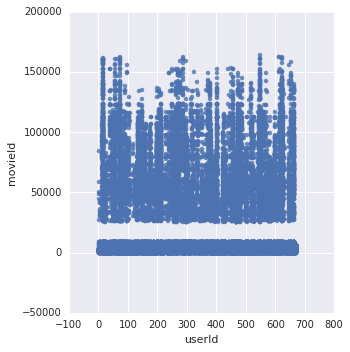

In [22]:
import seaborn as sns
%matplotlib inline

ratingsPandas = ratings.toPandas()
sns.lmplot(x='userId', y='movieId', data=ratingsPandas, fit_reg=False)

This matrix represents all the movies rated by users, but doesn't distinguish the ratings. Improve the graph by choosing a color palette to color the ratings:

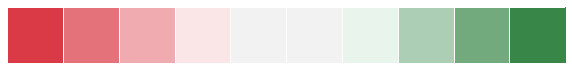

In [23]:
sns.palplot(sns.diverging_palette(10, 133, sep=80, n=10))

Create the graph on a larger scale with the color palette:

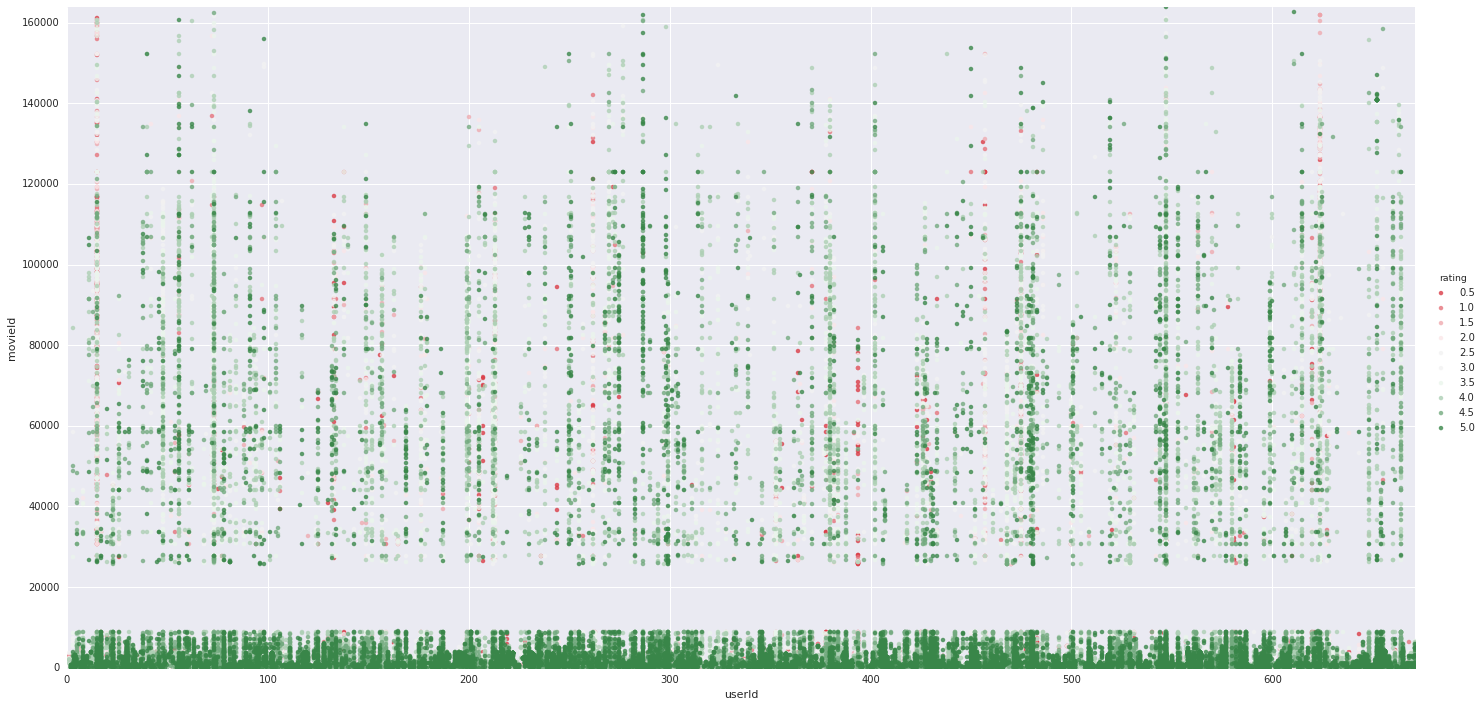

In [24]:
lm = sns.lmplot(x='userId', y='movieId', hue='rating', data=ratingsPandas, fit_reg=False, size=10, aspect=2, palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0,0].set_ylim(0,163949) # max movieId is 163949
axes[0,0].set_xlim(0,671) # max userId is 671
lm

On this matrix, you'll notice gaps in the data: some movies and users seem to be missing. This could be because you're using a subset of the data (the small data set).

Nevertheless, you can identify some patterns. Some users always give positive reviews of movies. Some movies are rated a lot, which could be for different reasons, such as the first release of the MovieLens website had a much smaller catalog, or the movies are more famous.

Now visualize the global distribution of ratings with a violin plot:

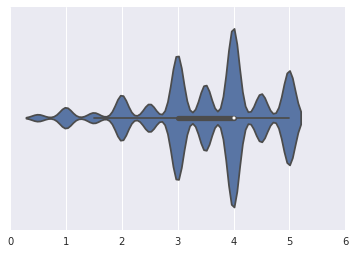

In [25]:
sns.violinplot([ratingsPandas.rating])

These are just two examples of what you can achieve with the rich Python visualization libraries ecosystem. Feel free to explore more!

## 5. Build the recommender system

There are different methods for building a recommender system, such as, user-based, content-based, or collaborative filtering. Collaborative filtering calculates recommendations based on similarities between users and products. For example, collaborative filtering assumes that users who give the similar ratings on the same movies will also have similar opinions on movies that they haven't seen.

The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous ratings.

In this case, the ALS algorithm will create a matrix of all users versus all movies. Most cells in the matrix will be empty. An empty cell means the user hasn't reviewed the movie yet. The ALS algorithm will fill in the probable (predicted) ratings, based on similarities between user ratings. The algorithm uses the least squares computation to minimize the estimation errors, and alternates between solving for movie factors and solving for user factors.

The following trivial example gives you an idea of the problem to solve. However, keep in mind that the general problem is much harder because the matrix often has far more missing values.

![User\Product matrix](https://github.com/hatv/dsx_SparkLessons/blob/master/als.png?raw=true "User\Product matrix")

Check the size of the ratings matrix:

In [26]:
spark.sql("""
    SELECT *, 100 * nb_ratings/matrix_size AS percentage
    FROM (
        SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
        FROM (
            SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movieId)) AS nb_movies, COUNT(DISTINCT(userId)) AS nb_users
            FROM ratings
        )
    )
""").show()

+--------+---------+----------+-----------+------------------+
|nb_users|nb_movies|nb_ratings|matrix_size|        percentage|
+--------+---------+----------+-----------+------------------+
|     671|     9066|    100004|    6083286|1.6439141608663477|
+--------+---------+----------+-----------+------------------+



Less than 2% of the matrix is filled!

### 5.1 Train the model

Use the SparkML ALS algorithm to train a model to provide recommendations. The mandatory parameters to the ALS algorithm are the columns that identify the users, the items, and the ratings. Run the `fit()` method to train the model:

In [27]:
from pyspark.ml.recommendation import ALS

model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating").fit(ratings)

### 5.2 Run the model

Run the `transform()` method to score the model and output a DataFrame with an additional prediction column that shows the predicted rating:

In [28]:
predictions = model.transform(ratings)
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    148|   4.0|1012605106| 3.9296763|
|   534|    463|   4.0| 973377486| 3.8960395|
|   232|    463|   4.0| 955089443| 3.7899709|
|   452|    463|   2.0| 976424451| 2.4852738|
|   380|    463|   3.0| 968949106|  2.994227|
|   242|    463|   4.0| 956685706|  3.825628|
|    30|    463|   4.0| 945277405|  3.694391|
|   311|    463|   3.0| 898008246| 2.8816297|
|   548|    471|   4.0| 857407799| 3.5204072|
|   602|    471|   3.0| 842357922| 3.9699168|
|   274|    471|   5.0|1074104142|  3.855192|
|    86|    471|   4.0| 848161161|  4.077562|
|   292|    471|   3.5|1140049920| 3.8318632|
|   306|    471|   3.0| 939718996| 3.5498383|
|    19|    471|   3.0| 855192558| 3.8663166|
|    15|    471|   3.0|1166586067|  3.092804|
|    23|    471|   3.5|1148730134| 3.6396422|
|   514|    471|   4.0| 853893788| 4.0214295|
|   624|    471|   4.0|1178980875|

You can see that many of the predictions are close to the actual ratings.

### 5.3 Evaluate the model
After you apply a model to a data set, you should evaluate the performance of the model by comparing the predicted values with the original values. Use the [RegressionEvaluator](http://spark.apache.org/docs/2.0.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) method to compare continuous values with the root mean squared calculation. The root mean squared error (RMSE) calculation measures the average of the squares of the errors between what is estimated and the existing data. The lower the mean squared error value, the more accurate the model. 

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions))

The root mean squared error for our model is: 0.609128453149


You want the performance score to improve with your design iterations so that the model is improved. But notice that you just ran the training and the scoring on the same data set. That's something that you won't normally do because you usually want to predict values that you don't already know! Therefore, this result is nonsense. To accurately evaluate the model, it's common practice in machine learning to split the data set between a training data set to train the model, and a test data set to compare the predicted results with the original results. This process is called cross-validation. Not doing cross-validation often leads to overfitting, which occurs when the model is too specific to the training data set and does not perform well on a more general data set. Here's the general iterative process of machine learning:

<img src="https://github.com/hatv/dsx_SparkLessons/blob/master/machine-learning.png?raw=true" alt="Machine Learning" style="width: 1000px;"/>

### 5.4 Split the data set
Split your ratings data set between an 80% training data set and a 20% test data set. Then rerun the steps to train the model on the training set, run it on the test set, and evaluate the performance.

In [30]:
(trainingRatings, testRatings) = ratings.randomSplit([80.0, 20.0])

In [31]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(trainingRatings)
predictions = model.transform(testRatings)

In [32]:
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|    92|    471|   4.0| 848526594| 3.3122451|
|   241|    471|   4.0| 847340064|   3.22489|
|   514|    471|   4.0| 853893788| 3.9485867|
|   574|    471|   3.5|1232817270| 3.5421128|
|    30|    471|   4.0| 945112993| 3.9363332|
|    85|    471|   3.0| 837512312| 2.8916008|
|   548|    471|   4.0| 857407799| 3.3342328|
|   649|    471|   3.0| 834425145| 3.4681005|
|   509|    471|   4.0| 939329728| 3.5564888|
|   659|    471|   4.0| 853412972| 3.2659414|
|   102|    471|   5.0| 958248997|  4.079501|
|   497|    496|   2.0| 939767844|  2.969569|
|   247|    833|   3.0| 953362750| 1.7808886|
|   296|    833|   4.5|1298158960| 2.0823536|
|   461|   1088|   3.0|1090908700| 2.5931113|
|   212|   1088|   3.5|1218955664| 3.0200448|
|   387|   1088|   4.0| 974790964|  3.301039|
|   509|   1088|   2.0|1093295913| 2.6561027|
|   281|   1088|   4.0|1113683947|

In [33]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions))

The root mean squared error for our model is: nan


You might get the value `nan` (not a number) from the previous cell.

### 5.5 Handle NaN results

A NaN result is due to [SPARK-14489](https://issues.apache.org/jira/browse/SPARK-14489) and because the model can't predict values for users for which there's no data. A temporary workaround is to exclude rows with predicted NaN values or to replace them with a constant, for instance, the general mean rating. However, to map to a real business problem, the data scientist, in collaboration with the business owner, must define what happens if such an event occurs. For example, you can provide no recommendation for a user until that user rates a few items. Alternatively, before user rates five items, you can use a user-based recommender system that's based on the user's profile (that's another recommender system to develop). 

Replace predicted NaN values with the average rating and evaluate the model:

In [34]:
avgRatings = ratings.select('rating').groupBy().avg().first()[0]
print "The average rating in the dataset is: " + str(avgRatings)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(avgRatings)))

The average rating in the dataset is: 3.54360825567
The root mean squared error for our model is: 0.921868326302


Now exclude predicted NaN values and evaluate the model:

In [35]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.drop()))

The root mean squared error for our model is: 0.910139049797


Obviously, you get lower performance than with the previous model, but you're protected against overfitting: you will actually get this level of performance on new incoming data!

### 5.6 Improve the performance score

If you run the `randomSplit()`, `fit()`, `transform()`, and `evaluate()` functions several times, you won't always get the same performance score. This is because the `randomSplit()` and `ALS()` functions have some randomness. To get a more precise performance score, run the model several times and then compute the average performance score. This process is really close to what is called k-fold cross validation. 

Create a `repeatALS()` function that trains, runs, and evaluates the model multiple times:

In [36]:
def repeatALS(data, k=3, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    for i in range(0, k):  
        (trainingSet, testingSet) = data.randomSplit([k-1.0, 1.0])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print "Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation)
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))

Run `repeatALS` four times and average the performance scores:

In [37]:
print "RMSE = " + str(repeatALS(ratings, k=4))

Loop 1: rmse = 0.921306301624
Loop 2: rmse = 0.917554133513
Loop 3: rmse = 0.91799624727
Loop 4: rmse = 0.916662890042
RMSE = 0.918379893112


The computed performance score is more stable this way. 

Create a `kfoldALS()` function that also trains, runs, and evaluates the model, but splits up the data between training and testing data sets in a different way. The original data set is split into k data sets. Each of the k iterations of the function uses a different data set for testing and the other data sets for training. 

In [38]:
def kfoldALS(data, k=3, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    weights = [1.0] * k
    splits = data.randomSplit(weights)
    for i in range(0, k):  
        testingSet = splits[i]
        trainingSet = spark.createDataFrame(sc.emptyRDD(), data.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                trainingSet = trainingSet.union(splits[j])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print "Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation)
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))

Compute the average performance score for 4 folds:

In [39]:
print "RMSE = " + str(kfoldALS(ratings, k=4))

Loop 1: rmse = 0.924292172308
Loop 2: rmse = 0.921572226733
Loop 3: rmse = 0.919547100868
Loop 4: rmse = 0.924288600436
RMSE = 0.922425025086


Now compute the average performance score for 10 folds:

In [40]:
print "RMSE = " + str(kfoldALS(ratings, k=10))

Loop 1: rmse = 0.899430908828
Loop 2: rmse = 0.907997049581
Loop 3: rmse = 0.906549165062
Loop 4: rmse = 0.904696508478
Loop 5: rmse = 0.894843650402
Loop 6: rmse = 0.892761449106
Loop 7: rmse = 0.902655917837
Loop 8: rmse = 0.892293586307
Loop 9: rmse = 0.910780404704
Loop 10: rmse = 0.906707887135
RMSE = 0.901871652744


Recall that you want to minimize the RMSE. And that 10 folds means a training set of 90% of the data, while 4 folds means a training training set of 75% of the data. The bigger the training set is, the better performance you get. A general assumption in machine learning is that more data usually beats a better algorithm. You can easily improve this performance score by using the full data set.

### 5.7 Improve the model

So now, how can you improve this model? Machine learning algorithms have hyperparameters that control how the algorithm works.

The ALS algorithm has this signature:
```python
    class pyspark.ml.recommendation.ALS(
        rank=10,
        maxIter=10,
        regParam=0.1,
        numUserBlocks=10,
        numItemBlocks=10,
        implicitPrefs=false,
        alpha=1.0,
        userCol="user",
        itemCol="item",
        seed=None,
        ratingCol="rating",
        nonnegative=false,
        checkpointInterval=10,
        intermediateStorageLevel="MEMORY_AND_DISK",
        finalStorageLevel="MEMORY_AND_DISK"
    )
```

The ALS hyperparameters are:
- `rank` = the number of latent factors in the model
- `maxIter` = the maximum number of iterations 
- `regParam` = the regularization parameter

To test several values for those **hyperparameters** and choose the best configuration, it's common practice to define a grid of parameter combinations and to run a **grid search** over the combinations to evaluate the resulting models and comparing their performance. This process is known as **model selection**. 

The Spark [CrossValidator function](https://spark.apache.org/docs/2.0.2/ml-tuning.html#cross-validation) performs a grid search as well as k-fold cross validation.  
Run the CrossValidator function with multiple values for `rank` and `regParam`:

In [41]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = ratings.randomSplit([90.0, 10.0])
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

paramGrid = ParamGridBuilder().addGrid(als.rank, [1, 5, 10]).addGrid(als.maxIter, [20]).addGrid(als.regParam, [0.05, 0.1, 0.5]).build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.drop()))

The root mean squared error for our model is: 0.935190718617


The more folds and parameters you add to the grid, the longer it takes to test any  combination. The `CrossValidator` model contains more information about the performance for each combination that you can get with the `avgMetrics()` method. For example, you can graph the results on a plot for analysis. 

Unfortunately, because of the [SPARK-14489](https://issues.apache.org/jira/browse/SPARK-14489) issue mentioned above, the CrossValidator function can't compute the root mean squared error most of the time and provides incorrect results. You could limit this problem by making the training set much larger than the test set, but that's not a good practice. If you want to learn more about this issue, which is more a conceptual one than a technical one, and how this is being solved in the next Spark 2.2 release, you can have a look at Nick Pentreath's pull request [#12896](https://github.com/apache/spark/pull/12896). Welcome to the Open Source world!

### 5.8 Recommend movies

To recommend movies for a specific user, create a function that applies the trained model, `ALSModel`, on the list of movies that the user hasn't yet rated.

Create a `recommendMovies` function:

In [44]:
from pyspark.sql.functions import lit

def recommendMovies(model, user, nbRecommendations):
    # Create a Spark DataFrame with the specified user and all the movies listed in the ratings DataFrame
    dataSet = ratings.select("movieId").distinct().withColumn("userId", lit(user))

    # Create a Spark DataFrame with the movies that have already been rated by this user
    moviesAlreadyRated = ratings.filter(ratings.userId == user).select("movieId", "userId")

    # Apply the recommender system to the data set without the already rated movies to predict ratings
    predictions = model.transform(dataSet.subtract(moviesAlreadyRated)).dropna().orderBy("prediction", ascending=False).limit(nbRecommendations).select("movieId", "prediction")

    # Join with the movies DataFrame to get the movies titles and genres
    recommendations = predictions.join(movies, predictions.movieId == movies.movieId).select(predictions.movieId, movies.title, movies.genres, predictions.prediction)

    recommendations.show(truncate=False)

Now run this function to recommend 10 movies for three different users:

In [45]:
print "Recommendations for user 133:"
recommendMovies(model, 133, 10)
print "Recommendations for user 471:"
recommendMovies(model, 471, 10)
print "Recommendations for user 496:"
recommendMovies(model, 496, 10)

Recommendations for user 133:
+-------+----------------------------------------+-------------------------------------------------+----------+
|movieId|title                                   |genres                                           |prediction|
+-------+----------------------------------------+-------------------------------------------------+----------+
|86000  |Boy (2010)                              |Comedy|Drama                                     |3.6398487 |
|128620 |Victoria (2015)                         |(no genres listed)                               |3.6398487 |
|134853 |Inside Out (2015)                       |Adventure|Animation|Children|Comedy|Drama|Fantasy|3.85611   |
|250    |Heavyweights (Heavy Weights) (1995)     |Children|Comedy                                  |3.8985798 |
|127108 |Brooklyn (2015)                         |Drama|Romance                                    |3.6398487 |
|71264  |Cloudy with a Chance of Meatballs (2009)|Animation|Children|Fanta

## 6. Summary and next steps


Here are some suggestions to improve your model:

 - Build a confusion matrix to understand where your model is good and where it is bad. The matrix should be 10x10 where the rows are the ratings, the columns are the predictions, and each cell shows the number of predictions in each class (0.5, 1.0, 1.5, etc.) for each real rating. The matrix diagonal should ideally contain all the values. You could plot this matrix as a heatmap with matplotlib.
 - Bound the predicted ratings between 0.5 and 5. 
 - Use more data, like tags or timestamps.   
 - Run the model on the full data set. Compare the execution time and the results. Downloading the full data set to your computer and then loading it into DSX might take a lot of time, depending on your network configuration. You can load the data set directly from GroupLens servers to your DSX environment, but that method isn't described in this notebook. 

## Author

Victor Hatinguais is a Client Technical Specialist at IBM. He specializes in technology evangelism, training, demos, and proofs of concept around Data Science and Big Data technologies, such as, Apache Hadoop and IBM BigInsights, Apache Spark, IBM Streams, and IBM SPSS.

## Data citation

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

<hr>
Copyright &copy; IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.